In [25]:
%matplotlib inline
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import numpy as np

spark = SparkSession.builder.appName("mnist").getOrCreate()
df = spark.read.json('/project/cmsc25025/mnist/data.json')

# split into training, development, and test sets
train, dev, test = df.rdd.randomSplit([4, 1, 1])
data = train.toDF().limit(10000)

# compute column-wise mean and standard deviation
mean = data.rdd.map(lambda x: np.array(x['features'])).mean()
stdev = data.rdd.map(lambda x: np.array(x['features'])).stdev()

def normalizer(x, mu, sigma):  
        return (x - mu)/sigma 

# standardize the data
standard = data.rdd.map(lambda x: [normalizer(x['features'], mean, stdev)]).reduce(lambda a, b: a + b)
strddata = map(np.nan_to_num , standard) # removes all NaN


In [21]:
# compute the covariance matrix
formatted = spark.sparkContext.parallelize(strddata)
C = np.array(formatted.map(lambda x: np.outer(x,x)).reduce(lambda a, b: np.add(a,b)))/784

# eigendecomposition of the covariance matrix
Eval, Evec = np.linalg.eigh(C)
Eval = np.absolute(Eval)
idx = np.argsort(Eval)[::-1] # sort in descending order
Eval = Eval[idx]
Evec = Evec[:,idx]

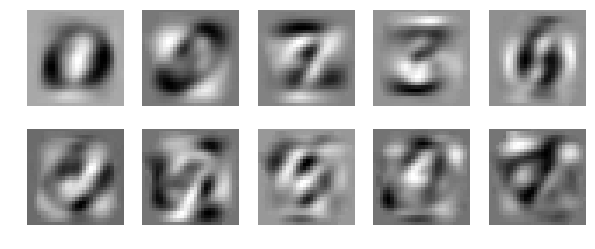

In [3]:
# display first 10 principal components as images
subset = np.transpose(eigvec[:,:10])

nrows = 2
ncols = 5
plt.figure(figsize=(ncols*2, nrows*2))
for i in xrange(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(subset[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
plt.axis('off')
plt.show()

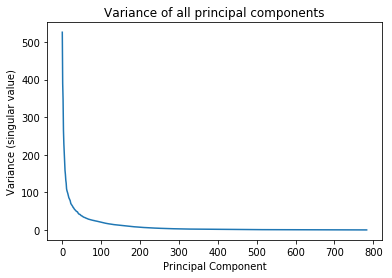

In [15]:
# plot variance explained versus principal component
plt.figure()
plt.plot(Eval)
plt.xlabel('Principal Component')
plt.ylabel('Variance (singular value)')
plt.title('Variance of all principal components')
plt.show()

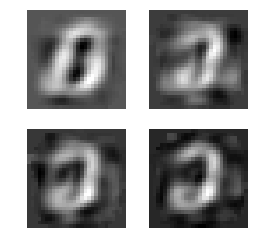

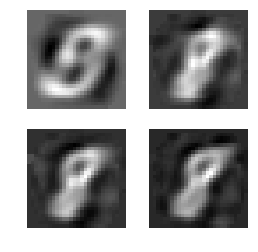

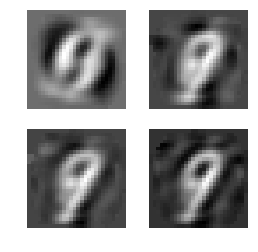

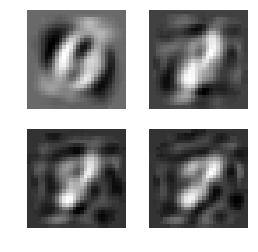

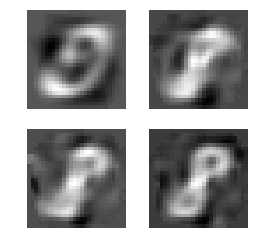

In [6]:
# obtain 5 test points for dimensionality reduction
points = test.toDF().limit(5)
fetpoints = points.rdd.map(lambda x: [np.array(x['features'])]).reduce(lambda a, b: a + b)

for i in range(len(fetpoints)):
    
    subset = np.zeros((4,784))
    for j,m in enumerate(range(5, 45, 10)):
        vals = np.dot(fetpoints[i],Evec[:,:m]) # projection coefficients
        proj = np.dot(vals,np.transpose(Evec[:,:m])) # transform back
        subset[j] = proj
        
    # plot reconstructions
    nrows = 2
    ncols = 2        
    plt.figure(figsize=(ncols*2, nrows*2))
    for j in xrange(nrows*ncols):
        plt.subplot(nrows, ncols, j+1)
        plt.imshow(subset[j].reshape((28,28)), cmap='gray')
        plt.axis('off')       
    plt.axis('off')
    plt.savefig('mnist_train_%d_%d.png' % (nrows, ncols))
    plt.show()

Even a small portion of principal components creates a decent representation of the images; however, the reconstruction of the images generally gets better as m increases. As shown above, the top principal components are capturing different numbers, which makes sense in terms of capturing the most variance.

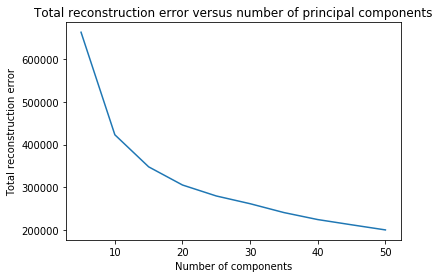

In [7]:
def sumsqrerr(vals, m): 
    v = np.dot(vals,Evec[:,:m])
    dimred = np.dot(v,np.transpose(Evec[:,:m]))
    diff = np.subtract(vals,dimred)
    return np.sum(np.square(diff))

# compute and plot total reconstruction error over multiple k
kvalues = [k for k in range (5,55,5)]
errors = [0] * len(kvalues)
for i, k in enumerate(kvalues):
    errors[i] = test.map(lambda x: sumsqrerr(x['features'], k)).reduce(lambda a, b: a + b)

plt.figure()
plt.plot(kvalues,errors)
plt.xlabel('Number of components')
plt.ylabel('Total reconstruction error')
plt.title('Total reconstruction error versus number of principal components')
plt.show()    

In [13]:
from pyspark.mllib.clustering import KMeans 

# train Kmeans model
training = data.rdd.map(lambda x: [np.array(x['features'])]).reduce(lambda a, b: a + b)
print type(training)
rdd = spark.sparkContext.parallelize(training)
print type(rdd)
clusters = KMeans.train(rdd,10, maxIterations=50,initializationMode = "random" ) 

def clustcenter(feat, label):
    cent = clusters.predict(feat)
    return cent, label

# record counts of (cluster,label) pairs for all points in training set
clust_label = data.rdd.map(lambda x : [clustcenter(x['features'], x['label'])]).reduce(lambda a, b: a + b)
count = spark.sparkContext.parallelize(clust_label).countByValue()

<type 'list'>
<class 'pyspark.rdd.RDD'>


In [14]:
# reformat the counts
x = dict()
for key in count: 
    clust =  key[0]
    label =  key[1]
    num = count[key]
    try: 
        x[clust].append((label, num))
    except KeyError:
        x[clust] = [(label, num)]

# sort counts in decreasing order
for key in x: 
    x[key].sort(key=lambda x: x[1], reverse = True)

# find majority label
labelsdict = dict ()
for key in x: 
    total = sum(n for _, n in x[key])
    purity = x[key][0][1]/ float(total)
    majlabel = x[key][0][0]
    labelsdict[key] = (majlabel, purity)

print "Below is a dictionary where the key is the cluster number and the values are the majority label of that cluster along with the purity."
print labelsdict
print "For the most part, the majority label is unique for each cluster. However, with this training set 0 is the majority label for two clusters."

Below is a dictionary where the key is the cluster number and the values are the majority label of that cluster along with the purity.
{0: (1, 0.6904761904761905), 1: (8, 0.6217948717948718), 2: (1, 0.5217391304347826), 3: (5, 0.33519553072625696), 4: (7, 0.39473684210526316), 5: (7, 0.48128342245989303), 6: (3, 0.4528985507246377), 7: (6, 0.5856573705179283), 8: (4, 0.5275229357798165), 9: (0, 0.9673202614379085)}
For the most part, the majority label is unique for each cluster. However, with this training set 0 is the majority label for two clusters.


This is cluster number 0, The majority Label for this cluster is 3 
Here is an example number:


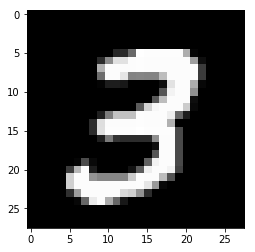

This is cluster number 1, The majority Label for this cluster is 0 
Here is an example number:


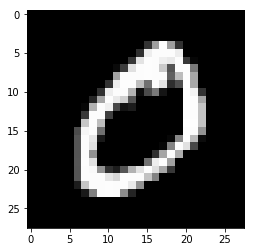

This is cluster number 2, The majority Label for this cluster is 7 
Here is an example number:


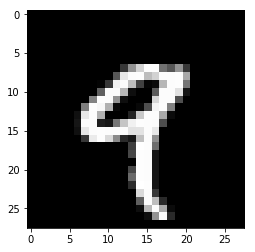

This is cluster number 3, The majority Label for this cluster is 8 
Here is an example number:


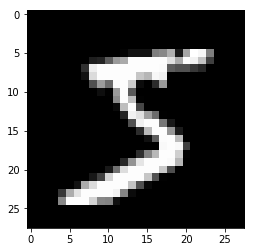

This is cluster number 4, The majority Label for this cluster is 1 
Here is an example number:


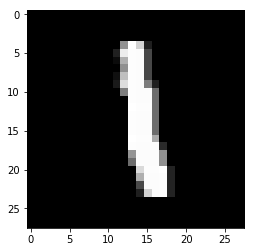

This is cluster number 5, The majority Label for this cluster is 1 
Here is an example number:


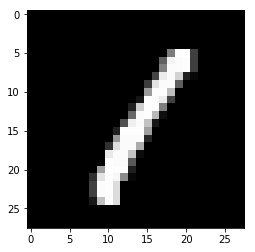

This is cluster number 6, The majority Label for this cluster is 6 
Here is an example number:


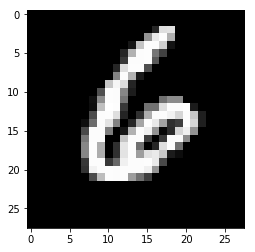

This is cluster number 7, The majority Label for this cluster is 2 
Here is an example number:


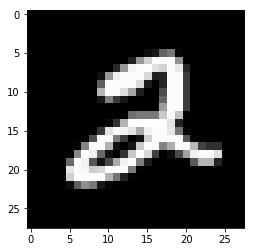

This is cluster number 9, The majority Label for this cluster is 4 
Here is an example number:


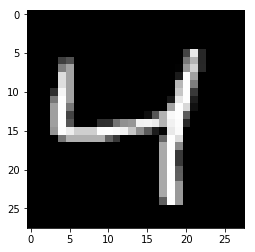

While the majority labels are mostly unique and respect the separation of digits, there are still other numbers represented within each cluster.
As such, the clusters overall do not very well respect the separation of digits.


In [39]:
# build lists of sample images from each cluster
clust = dict()
for i in range (0,40): 
    try: 
        clust[clusters.predict(training[i])].append(training[i])
    except KeyError:
        clust[clusters.predict(training[i])] = [training[i]]

# display the sample images
for key in clust: 
    print "This is cluster number %d, The majority Label for this cluster is %d " % (key, labelsdict[key])
    print "Here is an example number:"
    plt.figure()
    plt.imshow(clust[key][0].reshape((28,28)), cmap='gray')
    plt.show()

While the majority labels are mostly unique and respect the separation of digits, there are still other numbers represented within each cluster. As such, the clusters overall do not very well respect the separation of digits.

In [11]:
import math 
import scipy.linalg
import scipy.sparse.linalg

# get cartesian product of 2000 images
data = train.toDF().limit(2000)
spec = data.rdd.map(lambda x: [np.array(x['features'])]).reduce(lambda a, b: a + b)
specl = spark.sparkContext.parallelize(spec)
x = specl.cartesian(specl)

def computedist(xi, xj, h): 
    return math.exp(- math.pow(np.linalg.norm(np.subtract(xi, xj)) , 2)/ h)

# compute the Laplacian
a = x.map(lambda x: computedist( x[0], x[1] , 3)).collect()
A = np.array(a)
A.shape = (2000, 2000)
neghalfD =  np.diag(np.power(np.sum(A, axis=1) , -.5)) 
L = np.subtract(np.identity(2000), np.dot(np.dot(A,neghalfD), neghalfD))

# obtain bottom eigenvectors of L
lambda_1, eigvec = scipy.sparse.linalg.eigs(L, k=1)
transformed = lambda_1 * np.identity(2000) - L
eigval, eigvec =scipy.sparse.linalg.eigs(transformed, k = 4)
f = eigvec[:,1:] # remove the last eigenvector

# How is the spectrum of L related to the spectrum of A? What’s the last eigenvector of L?

In [12]:
# run kmeans on reduced dimensionality
reduced = spark.sparkContext.parallelize(f).repartition(1)
clusters = KMeans.train(reduced,10, maxIterations=50,initializationMode = "random" ) 

# add back in the labels
labels = data.rdd.map(lambda x: [x['label']]).repartition(1) 
h = reduced.zip(labels)

# record counts of (cluster,label) pairs for all points in training set
clust_label = h.map(lambda x : [clustcenter(x[0], x[1][0])]).reduce(lambda a, b: a + b)
count = spark.sparkContext.parallelize(clust_label).countByValue()

# reformat the counts
x = dict()
for key in count: 
    clust =  key[0]
    label =  key[1]
    num = count[key]
    try: 
        x[clust].append((label, num))
    except KeyError:
        x[clust] = [(label, num)]

# sort counts in decreasing order
for key in x: 
    x[key].sort(key=lambda x: x[1], reverse = True) 

# find majority label
labelsdict = dict ()
for key in x: 
    total = sum(n for _, n in x[key])
    purity = x[key][0][1]/ float(total)
    majlabel = x[key][0][0]
    labelsdict[key] = (majlabel, purity)
    
print "Below is a dictionary where the key is the cluster number and the values are the majority label of that cluster along with the purity."
print labelsdict

Below is a dictionary where the key is the cluster number and the values are the majority label of that cluster along with the purity.
{0: (8, 0.2857142857142857), 1: (1, 0.23076923076923078), 2: (2, 0.25), 3: (0, 0.18181818181818182), 4: (8, 0.25), 5: (4, 0.1149843912591051), 6: (2, 0.2222222222222222), 7: (4, 0.375), 8: (5, 0.2222222222222222), 9: (3, 0.3333333333333333)}


The purity of clusters is lower for spectral clustering than for kmeans on the raw pixel values. This makes sense since we are only considering a handful of features.

In [23]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint 

def projfunc (x, k): 
     return np.dot(x, Evec[:,:k])

def error (x, y): 
    p = model.predict(x)
    return y == p 


# build regression model on raw features
formats = train.map(lambda x: [LabeledPoint(x['label'], x["features"])]).reduce(lambda a,b : a + b)
model = LogisticRegressionWithLBFGS.train(spark.sparkContext.parallelize(formats), iterations=10, numClasses=10)
err = dev.map(lambda x: [error(x["features"], x["label"])]).collect()
errorate =  1 -  float(sum(sum(x) for x in err) / float(len(err)))
print "error rate of multinomial regission is %.34f" % (errorate)


error rate of multinomial regission is 0.1093629094660820699758119189937133


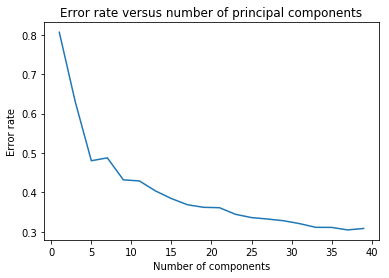

The error rate decreases as k increases.


In [24]:
# build regression models on training set for multiple values of k
# compute the error rate for each k

def projerror (x, y, k): 
    r = projfunc(x, k)
    p = model.predict(r)
    return y == p

kvalues = [k for k in range (1,41,2)]
errors = [0] * len(kvalues)
for index, k in enumerate(kvalues):
    
    proj = train.map(lambda x: [LabeledPoint(x['label'], projfunc(x["features"], k))]).reduce(lambda a,b : a + b)     
    model = LogisticRegressionWithLBFGS.train(spark.sparkContext.parallelize(proj), iterations=2, numClasses=10)
    err = dev.map(lambda x: [projerror(x["features"], x["label"], k)]).collect()
    errorate =  1 -  float(sum(sum(x) for x in err) / float(len(err)))
    errors[index] = errorate


# plot error rate versus k    
plt.figure()
plt.plot(kvalues,errors)
plt.xlabel('Number of components')
plt.ylabel('Error rate')
plt.title('Error rate versus number of principal components')
plt.show()
print "The error rate decreases as k increases."

In [27]:
# find k with lower error rate, build regression model with training + development set
bestk = kvalues[errors.index(min(errors))]
newdata = spark.sparkContext.union([train,dev])

# compute the error rate
proj = newdata.map(lambda x: [LabeledPoint(x['label'], projfunc(x["features"], bestk))]).reduce(lambda a,b : a + b)     
model = LogisticRegressionWithLBFGS.train(spark.sparkContext.parallelize(proj), iterations=10, numClasses=10)
err = test.map(lambda x: [projerror(x["features"], x["label"], bestk)]).collect()
errorate =  1 -  float(sum(sum(x) for x in err) / float(len(err)))

print "Error rate for multinomial logistic regression on training + dev with %d principal components" % bestk
print errorate
 

Error rate for multinomial logistic regression on training + dev with 37 principal components
0.146751790182


Written answer for part B: As can be seen in the plot above. As K increases the error rate decreases. The rate that the error rate decreases at is large at first and as we get to larger k the error rate goes down by less as we increase k. When k reaches about 37 the error rate starts to increase again. This is probably because we are over fitting the data.

Written answer for Part C: When we did the multinomial regression using the raw features we got an error rate of .109. The error rate we got with the best projection is .146. This is remarkably close to the error rate we get when we use all of the raw features.

In [14]:
spark.stop()